In [1]:
# Articles
# https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import datetime as dt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
data = pd.read_csv("../data/state-daily-stats.csv")
data.drop(columns={"Unnamed: 0"}, inplace=True)

In [4]:
for index, row in data.iterrows():
    date = dt.datetime.strptime(row["date"], "%Y-%d-%m")
    date2 = dt.datetime.strftime(date, "%m-%d-%Y")
    data.at[index, "date"] = date2

In [5]:
data["date"] = pd.to_datetime(data["date"])
daily_new_cases = pd.DataFrame(data[["date","daily_new_cases"]])

In [6]:
daily_new_cases

,date,daily_new_cases
0,2020-01-21,1
1,2020-01-22,0
2,2020-01-23,0
3,2020-01-24,1
4,2020-01-25,1
...,...,...
406,2021-03-02,57789
407,2021-03-03,66714
408,2021-03-04,67415
409,2021-03-05,65682


In [7]:
daily_new_cases = daily_new_cases[daily_new_cases["date"] >= dt.datetime(2020,3,1)]
for index, row in daily_new_cases.iterrows():
    date = row["date"]
    new_date = dt.datetime.strftime(date, "%m-%d-%Y")
    daily_new_cases.at[index, "date"] = new_date

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
daily_new_cases

,date,daily_new_cases
40,03-01-2020,18
41,03-02-2020,16
42,03-03-2020,21
43,03-04-2020,36
44,03-05-2020,67
...,...,...
406,03-02-2021,57789
407,03-03-2021,66714
408,03-04-2021,67415
409,03-05-2021,65682


In [9]:
daily_new_cases.set_index("date", inplace=True)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

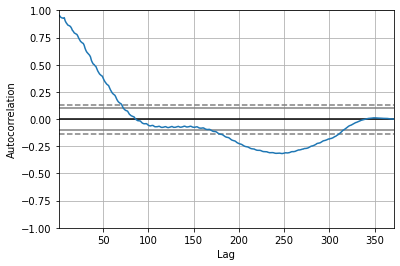

In [10]:
autocorrelation_plot(daily_new_cases)

In [11]:
test_df = np.log(daily_new_cases)
test_df.fillna(0, inplace=True)

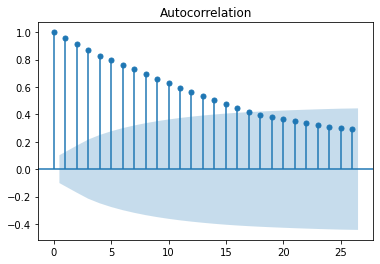

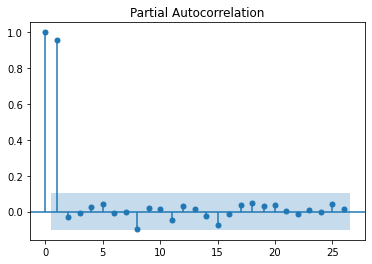

In [12]:
ACF = plot_acf(test_df)
PACF = plot_pacf(test_df)

In [13]:
result = adfuller(test_df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.3284240313071094
p-value: 0.013654753190020665


In [14]:
training = test_df[:250]
testing = test_df[250:]

In [16]:
testing

,daily_new_cases
date,
11-06-2020,11.796773
11-07-2020,11.743497
11-08-2020,11.546515
11-09-2020,11.778676
11-10-2020,11.847610
...,...
03-02-2021,10.964554
03-03-2021,11.108170
03-04-2021,11.118623


In [ ]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

model = ARIMA(training, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residuals")
plt.show()

In [ ]:
model_fit.plot_predict()
plt.show()

In [ ]:
model_1_pred = model_fit.predict(start="2020-11-06") 

In [ ]:
for x in model_1_pred:
    print(x)

### ARIMA / SARMIA Testing

In [ ]:
import pmdarima as pm

In [ ]:
amodel = pm.auto_arima(training, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=7,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(amodel.summary())

In [ ]:
amodel.plot_diagnostics(figsize=(20,5))
plt.show()

In [ ]:
n_periods = 119
arima_predictions = amodel.predict(n_periods=n_periods)

In [ ]:
arima = []
for x in arima_predictions:
    p = np.expm1(x)
    arima.append(round(p))
    
arima

In [ ]:
arima_df = pd.DataFrame(arima)
arima_df.rename(columns={0: "arima_model"}, inplace=True)

In [ ]:
testing

In [ ]:
arima_analysis = testing.reset_index()

for index, row in arima_analysis.iterrows():
    x = row[1]
    arima_analysis.at[index, "original_daily"] = np.expm1(x)

In [ ]:
arima_analysis = pd.merge(arima_analysis, arima_df, left_index=True, right_index=True)
arima_analysis.set_index("date", inplace=True)
arima_analysis.drop(columns="daily_new_cases", inplace=True)

In [ ]:
arima_analysis.plot()

In [ ]:
arima_analysis.plot(figsize=(20, 7))

## SARIMA Model: Grid Search

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(training, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

In [ ]:
n_periods = 120
predictions_seasonal = smodel.predict(n_periods=n_periods)

In [ ]:
pd.DataFrame(predictions_seasonal).plot()

In [ ]:
arima_analysis

In [ ]:
predictions_list = []

for x in predictions_seasonal:
    prediction = np.expm1(x)
    predictions_list.append(round(prediction))

In [ ]:
sarima_model = pd.DataFrame(predictions_list)
sarima_model.rename(columns={0:"sarima_model"}, inplace=True)

In [ ]:
sarima_model

In [ ]:
arima_analysis.reset_index(inplace=True)

In [ ]:
model_analyses = pd.merge(arima_analysis, sarima_model, left_index=True, right_index=True)
model_analyses.drop(columns={"index"}, inplace=True)

In [ ]:
model_analyses[:30].plot()

# Finalized Model Below - DO NOT DELET

**Fit model to all data**

In [25]:
# Take the log of all the data to make it stationary
training 

,daily_new_cases
date,
03-01-2020,2.890372
03-02-2020,2.772589
03-03-2020,3.044522
03-04-2020,3.583519
03-05-2020,4.204693
...,...
11-01-2020,11.214452
11-02-2020,11.451188
11-03-2020,11.434055


In [26]:
# Fit model
mod = sm.tsa.statespace.SARIMAX(training, trend='c', order=(1,1,1), seasonal_order=(1, 1, 2, 7))
res = mod.fit(disp=False)
print(res.summary())

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                       SARIMAX Results                                        
Dep. Variable:                        daily_new_cases   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood                 145.051
Date:                                Sun, 07 Mar 2021   AIC                           -276.102
Time:                                        18:04:26   BIC                           -251.680
Sample:                                    03-01-2020   HQIC                          -266.264
                                         - 11-05-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0168      0.011     -1.577      0.115      -0.038       0.004
ar.

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [28]:
training

,daily_new_cases
date,
03-01-2020,2.890372
03-02-2020,2.772589
03-03-2020,3.044522
03-04-2020,3.583519
03-05-2020,4.204693
...,...
11-01-2020,11.214452
11-02-2020,11.451188
11-03-2020,11.434055


In [29]:
# # SARIMAX(1, 1, 2)x(1, 1, 2, 7)
# mod = sm.tsa.statespace.SARIMAX(testing, trend='c', order=(1,1,1), seasonal_order=(1, 1, 2, 7))
# res = mod.fit(disp=False)
# print(res.summary())

In [30]:
SARIMA_predictions = res.forecast(steps=10)
SARIMA_new = pd.DataFrame(SARIMA_predictions)

In [31]:
SARIMA_new
for index, row in SARIMA_new.iterrows():
    sarima_p = round(np.expm1(row["predicted_mean"]))
    SARIMA_new.at[index, "sarima_model_new"] = sarima_p

In [32]:
SARIMA_new

,predicted_mean,sarima_model_new
2020-11-06,11.795380,132637.0
2020-11-07,11.635491,113038.0
2020-11-08,11.433248,92340.0
2020-11-09,11.609240,110110.0
2020-11-10,11.613486,110578.0
2020-11-11,11.691096,119502.0
2020-11-12,11.786473,131461.0
2020-11-13,11.864352,142108.0
2020-11-14,11.673311,117395.0
2020-11-15,11.486036,97346.0


In [33]:
observed = daily_new_cases[-121:]

In [34]:
observed

,daily_new_cases
date,
11-06-2020,132823
11-07-2020,125932
11-08-2020,103416
11-09-2020,130441
11-10-2020,139750
...,...
03-02-2021,57789
03-03-2021,66714
03-04-2021,67415


In [35]:
SARIMA_new.drop(columns={"predicted_mean"}, inplace=True)

In [36]:
SARIMA_new

,sarima_model_new
2020-11-06,132637.0
2020-11-07,113038.0
2020-11-08,92340.0
2020-11-09,110110.0
2020-11-10,110578.0
2020-11-11,119502.0
2020-11-12,131461.0
2020-11-13,142108.0
2020-11-14,117395.0
2020-11-15,97346.0


<AxesSubplot:>

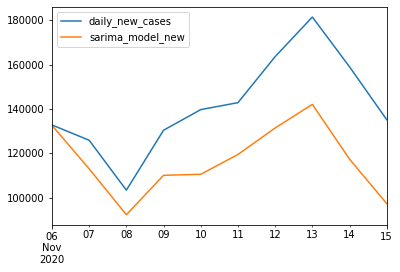

In [37]:
pd.merge(observed, SARIMA_new, left_index=True, right_index=True ).plot()

In [38]:
ten_day_observed = observed[:10]
ten_day_observed

,daily_new_cases
date,
11-06-2020,132823
11-07-2020,125932
11-08-2020,103416
11-09-2020,130441
11-10-2020,139750
11-11-2020,142885
11-12-2020,163640
11-13-2020,181497
11-14-2020,159033


In [39]:
first_ten_sarima = SARIMA_new[:10]
first_ten_sarima

,sarima_model_new
2020-11-06,132637.0
2020-11-07,113038.0
2020-11-08,92340.0
2020-11-09,110110.0
2020-11-10,110578.0
2020-11-11,119502.0
2020-11-12,131461.0
2020-11-13,142108.0
2020-11-14,117395.0
2020-11-15,97346.0


<AxesSubplot:>

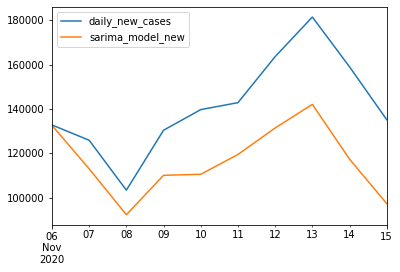

In [40]:
pd.merge(ten_day_observed, first_ten_sarima, left_index=True, right_index=True).plot()

In [41]:
log_daily_new_cases = np.log(daily_new_cases)

In [42]:
log_daily_new_cases

,daily_new_cases
date,
03-01-2020,2.890372
03-02-2020,2.772589
03-03-2020,3.044522
03-04-2020,3.583519
03-05-2020,4.204693
...,...
03-02-2021,10.964554
03-03-2021,11.108170
03-04-2021,11.118623


In [48]:
# # SARIMAX(1, 1, 2)x(1, 1, 2, 7)
final_mod = sm.tsa.statespace.SARIMAX(log_daily_new_cases, trend='c', order=(1,1,1), seasonal_order=(1, 1, 2, 7))
final_res = final_mod.fit(disp=False)
print(res.summary())

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                       SARIMAX Results                                        
Dep. Variable:                        daily_new_cases   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood                 145.051
Date:                                Sun, 07 Mar 2021   AIC                           -276.102
Time:                                        18:10:01   BIC                           -251.680
Sample:                                    03-01-2020   HQIC                          -266.264
                                         - 11-05-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0168      0.011     -1.577      0.115      -0.038       0.004
ar.

C:\Users\coled\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [49]:
final_res.forecast(steps=10)

2021-03-07    10.701466
2021-03-08    10.765168
2021-03-09    10.799076
2021-03-10    10.866094
2021-03-11    10.879217
2021-03-12    10.853179
2021-03-13    10.695271
2021-03-14    10.449313
2021-03-15    10.498899
2021-03-16    10.535021
Freq: D, Name: predicted_mean, dtype: float64

<AxesSubplot:>

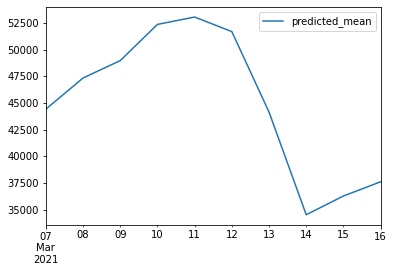

In [51]:
next_ten_days_prediction_df = pd.DataFrame(round(np.expm1(final_res.forecast(steps=10))))
next_ten_days_prediction_df.plot()

In [52]:
today = dt.date.today().strftime("%Y-%m-%d")
today

'2021-03-07'

In [53]:
next_ten_days_prediction_df.to_csv(f"../data/{today}_ten_day_prediction.csv", index_label="date")

In [54]:
next_ten_days_prediction_df

,predicted_mean
2021-03-07,44420.0
2021-03-08,47342.0
2021-03-09,48975.0
2021-03-10,52369.0
2021-03-11,53061.0
2021-03-12,51697.0
2021-03-13,44146.0
2021-03-14,34520.0
2021-03-15,36275.0
2021-03-16,37609.0


In [55]:
check = pd.read_csv("../data/state-daily-stats.csv", parse_dates=['date'])

In [56]:
check = check.loc[check["date"] == "2021-06-03"]

In [57]:
check

,Unnamed: 0,date,fips,cases,deaths,daily_new_cases,daily_new_deaths,3_month_immunity_est,6_month_immunity_est
410,410,2021-06-03,1762,28993824,523970,56606,1459,16039328.0,23062894.0
